# Analysis 1: Diachronic Frequencies Plots



Now we'll take the CONLL data and do some analysis. Our first step would be to plot word/lemma frequencies for months of year 1918 and see if they correlate with the waves of the flu pandemic


## 0. Imports and data upload

In [1]:
import pandas as pd

In [2]:
import re

In [3]:
from pathlib import Path

In [6]:
conllfiles = Path(r"../data/csv")

In [12]:
corpus_annotations = {}
for file in conllfiles.iterdir():
    if file.suffix == '.csv':
        #path = os.path.join(conllfiles, filename)  
        data = pd.read_csv(file) 
        corpus_annotations[file.name] = data

In [18]:
corpus_metadata = pd.read_csv(Path('../data/metadata/QUADRIGA_FS-Text-01_Data01_Corpus-Table.csv'), sep=';')

In [23]:
corpus_metadata = corpus_metadata.set_index('DC.identifier')

## 1. Search lemma and plot frequency

In [49]:
class WordSearchEngine:
    
    def __init__(self, corpus_annotated, corpus_metadata):
        self.prepare_index_dataframe_for_search(corpus_annotated, corpus_metadata)
    
    def prepare_index_dataframe_for_search(self, corpus_annotated, corpus_metadata):
        for filename, annotated_text in corpus_annotated.items():
            txtname = filename.replace('.csv', '')
            if txtname in corpus_metadata.index:
                year, month, day = self.get_date_fname(txtname, corpus_metadata)
                annotated_text['month'] = month
        self.full_df = pd.concat(corpus_annotated.values())
        self.monthly_word_counts = self.full_df.groupby('month').count().Token
        print(f'Searching in a corpus of {self.full_df.shape[0]} word occurences')
        
    def get_date_fname(self, txtname, corpus_metadata):  
        date = corpus_metadata.loc[txtname, 'DC.date']
        date = str(date)
        year = date[:4]
        month = f"{date[:7]}"
        day = date
        return year, month, day 
        
    def search_and_plot(self, absolute_freqs=False):
        search_term = input('Insert a word to search: ')
        if len(search_term) == 0:
            search_term = 'Grippe'
        result = self.full_df.query(f'Lemma=="{search_term}"')
        if absolute_freqs:
            absolute_freqs = result.groupby('month').count().Lemma
            absolute_freqs.plot(title=f'frequency of {search_term}');
            print(absolute_freqs)
        else:
            #print(monthly_word_counts)
            relative_freqs = result.groupby('month').count().Lemma/self.monthly_word_counts
            relative_freqs = relative_freqs.fillna(0)
            #print(relative_freqs)
            relative_freqs.plot(title=f'frequency of {search_term}')
            

In [50]:
engine = WordSearchEngine(corpus_annotations, corpus_metadata)

Searching in a corpus of 33165791 word occurences


Insert a word to search: Geld


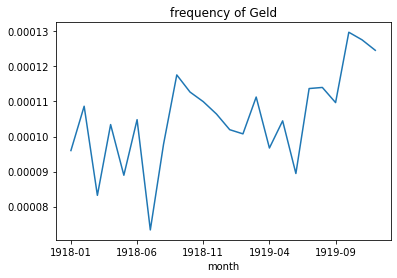

In [52]:
engine.search_and_plot()

## 3. Discussion of the intermediate result 

Is this result meaningful and does it actually reflect something? One way to check that is to compare our plot with the actual data about the intensity of the pandemic. 

In (Taubenberger, J. K., & Morens, D. M. (2006). 1918 Influenza: the Mother of All Pandemics. Emerging Infectious Diseases, 12(1), 15-22. https://doi.org/10.3201/eid1201.050979) it is stated that 'The first pandemic influenza wave appeared in the spring of 1918, followed in rapid succession by much more fatal second and third waves in the fall and winter of 1918–1919, respectively'. They also supplement this statement with a plot from an earlier paper (Jordan  E. (1927). Epidemic influenza: a survey. Chicago: American Medical Association):

<img src="https://wwwnc.cdc.gov/eid/images/05-0979-F1.gif">

Our two waves of mentions of the word 'Grippe' seem to correspond to the mortality figures, which could indicate that the method, albeit very simple, works and that historical events can sometimes be reflected in word frequency counts...